In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
from matplotlib import cm
from matplotlib import colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from dlt.model import PDFmodel
from dlt.distribution import Distribution

In [110]:
PLOT_FOLDER = Path('../doc/figs')
PLOT_FOLDER.mkdir(parents=True, exist_ok=True)

SAVE_PLOT = True

In [111]:
from dlt import data
from pathlib import Path
import importlib.resources as pkg_resources

data_path = Path(pkg_resources.files(data) / "BCDMS_data")
fk_grid = np.load(data_path / 'fk_grid.npy')
data = np.load(data_path / 'data.npy')
FK_original = np.load(data_path / 'FK.npy')
f_bcdms = np.load(data_path / 'f_bcdms.npy')
Cy = np.load(data_path / 'Cy.npy')

In [141]:
def plot_matrix(matrix, x_labels=None, x_ticklocks=None, fontsize=10, pad=10, y_labels=None, y_ticklocks=None, ax=None, norm='SymLog', **kwargs):
  # Show the FK tables
  if not isinstance(matrix, np.ndarray):
    matrix = np.array(matrix)

  if norm == 'SymLog':
    norm_f = mcolors.SymLogNorm(linthresh=0.00001, linscale=1, vmin=matrix.min(), vmax=matrix.max())
  elif norm == 'Log':
    norm_f = mcolors.LogNorm(vmin=matrix.min(), vmax=matrix.max())
  elif norm == 'Linear':
    norm_f = mcolors.Normalize(vmin=matrix.min(), vmax=matrix.max())
  else:
    raise ValueError(f"Unknown norm: {norm}")
  
  if ax is None:
    fig, ax = plt.subplots(**kwargs)
  else:
    fig = ax.figure
  
  matrixplot = ax.matshow(
      matrix,
      cmap=cm.Spectral_r,
      norm=norm_f
  )
  
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.5)
  cbar = fig.colorbar(matrixplot, cax=cax)
  cbar.ax.tick_params(labelsize=fontsize)

  if x_ticklocks is not None:
    ax.set_xticks(x_ticklocks)
  if x_labels is not None:
    ax.tick_params(axis='x', pad=pad, which='both', top=False, bottom=True, labeltop=False, labelbottom=True)
    _ = ax.set_xticklabels(x_labels, rotation=20, ha="right", fontsize=fontsize, va="center", rotation_mode="anchor")

  if y_labels is not None and y_ticklocks is not None:
    ax.set_yticks(y_ticklocks)
    _ = ax.set_yticklabels(y_labels, rotation=-20, ha="right", fontsize=fontsize, va="center", rotation_mode="anchor")
    ax.tick_params(axis='y', pad=pad)

  fig.tight_layout()
  return fig, ax

# Monkey patch to PDFmodel

In [142]:
import tensorflow.keras as keras
import tensorflow as tf

def get_preactivation(self, layer_idx, input_data):
    """
    Extract pre-activation values for a specific layer given input data
    
    Args:
        layer_idx (int): Index of the layer (0-indexed)
        input_data: Input data to the model
    """
    keras_model = self.model
    
    if layer_idx == 0:
        # For first layer, pre-activations are the inputs
        return input_data
    
    # Create a function that outputs the pre-activation (input to the layer)
    get_preact_fn = keras.Function(
        [keras_model.inputs[0]],
        [keras_model.layers[layer_idx].input]
    )
    
    # Get pre-activations
    return get_preact_fn([input_data])[0]

def compute_preactivation_product(self, layer_idx, input_data=None):
    """
    Compute the product of pre-activations:
    φ_{i1,α1}^(l) * φ_{i2,α2}^(l)
    """
    if input_data is None:
        input_data = self.inputs

    # Add batch dimension if missing
    if len(np.array(input_data).shape) == 2:  # If shape is (50, 1)
        input_data = np.expand_dims(input_data, axis=0)  # Make it (1, 50, 1)
    
    preactivations = self.get_preactivation(layer_idx, input_data)
    
    phi_alpha1_i1 = preactivations[0, :, :] # Shape: [data, neuron]
    phi_alpha2_i2 = preactivations[0, :, :] # Shape: [data, neuron]

    # Use tf.matmul with reshaping for the outer product
    # First reshape to column and row vectors
    # phi1_column = tf.reshape(phi_i1_alpha1, [-1, 1])  # Shape: [batch_size, 1]
    # phi2_row = tf.reshape(phi_i2_alpha2, [1, -1])     # Shape: [1, batch_size]
    
    # Compute outer product
    #tensor_product = tf.matmul(phi1_column, phi2_row)
    tensor_product = tf.einsum('ai,bj->aibj', phi_alpha1_i1, phi_alpha2_i2)
    
    return tensor_product

# Monkey patch the PDFmodel class
PDFmodel.get_preactivation = get_preactivation
PDFmodel.compute_preactivation_product = compute_preactivation_product

In [143]:
# Generating the models
replicas = 100
seed = 1423413
models = []
phi_a1a2_phi_i1i2_dist = Distribution("phi_a1a2_phi_i1i2_dist")
k1_norm_i1i2_dist = Distribution("k1_norm_i1i2")
for rep in range(replicas):
  model = PDFmodel(
          dense_layer='Dense',
          input=fk_grid,
          outputs=1,
          architecture=[25, 20],
          activations=['tanh', 'tanh'],
          kernel_initializer='GlorotNormal',
          user_ki_args=None,
          seed=seed + rep,
          init_bias=False)
  models.append(model)
  # k1_norm_i1i2 = np.linalg.norm(phi_a1a2_phi_i1i2, axis=(0, 1))
  # k1_norm_i1i2_dist.add(k1_norm_i1i2)


In [144]:
def compute_K_by_layer(model_ensemble: list[PDFmodel], layer_idx: int):
  """
  Compute the correlation matrix K for each layer in the model ensemble.
  
  The correlation matrix K is defined as
    K_{i1 α1,i2 α2} = < φ_{i1,α1}^(l) * φ_{i2,α2}^(l) >
  """
  res_distribution = Distribution("K distribution layer " + str(layer_idx))
  for model in model_ensemble:
    phi_a1a2_phi_i1i2 = model.compute_preactivation_product(layer_idx)
    res_distribution.add(phi_a1a2_phi_i1i2)
  return res_distribution

def compute_K_by_layer_infinity(K: np.ndarray, layer_idx: int):
  """
  Compute the correlation matrix K for each layer in the model ensemble.
  
  The correlation matrix K is defined as
    K_{i1 α1,i2 α2} = < φ_{i1,α1}^(l) * φ_{i2,α2}^(l) >
  """
  res = 0 
  return 

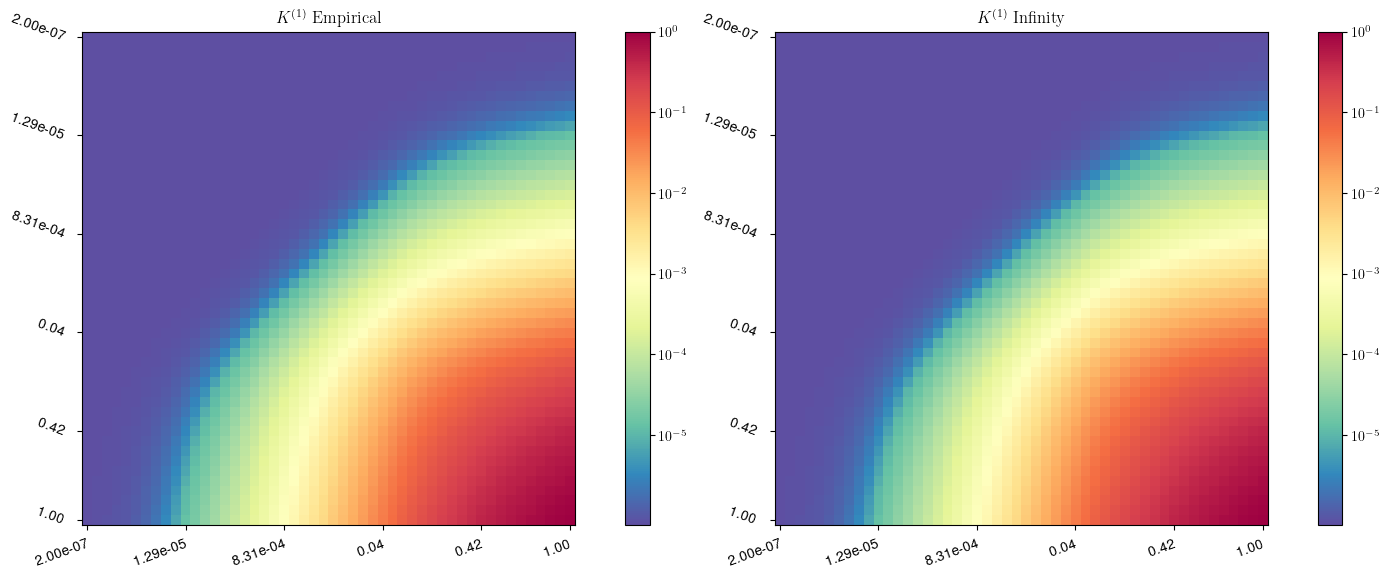

In [145]:
# Check first layer
K1_empirical = compute_K_by_layer(models, 0).get_mean(axis=0).squeeze()
K1_infinity = np.outer(fk_grid, fk_grid)

# Create a new figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ticks = np.arange(0, len(fk_grid), 10)
ticks = np.append(ticks, len(fk_grid) - 1)
labels = [f"{fk_grid[i]:.2e}" if fk_grid[i] < 1.e-3 else f"{fk_grid[i]:.2f}" for i in ticks]

fig1, axes[0] = plot_matrix(K1_empirical, ax=axes[0], x_labels=labels, x_ticklocks=ticks, y_labels=labels, y_ticklocks=ticks, pad=10)
fig2, axes[1] = plot_matrix(K1_infinity, ax=axes[1], x_labels=labels, x_ticklocks=ticks, y_labels=labels, y_ticklocks=ticks, pad=10)

# Add titles
axes[0].set_title(r"$K^{(1)} \textrm{ Empirical}$")
axes[1].set_title(r"$K^{(1)} \textrm{ Infinity}$")

plt.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'K1_correlations.pdf', dpi=300)

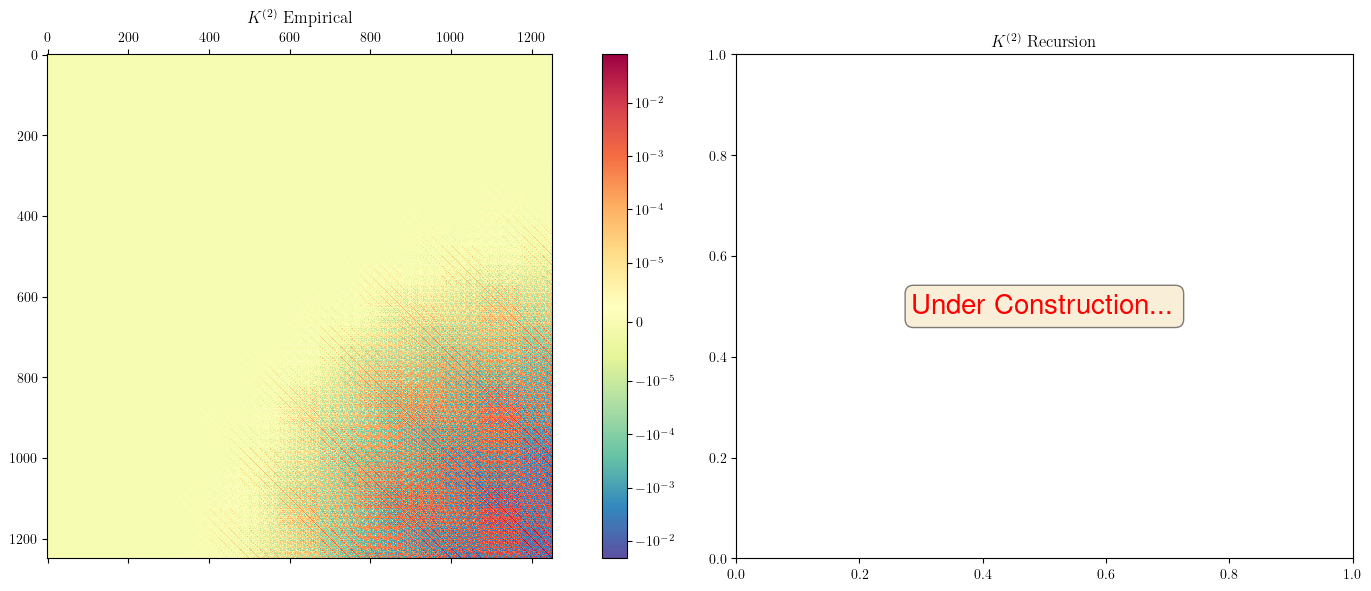

In [146]:
# Second layer
K2_empirical = compute_K_by_layer(models, 1).get_mean(axis=0)
K2_empirical = K2_empirical.reshape((K2_empirical.shape[0] * K2_empirical.shape[1], K2_empirical.shape[2] * K2_empirical.shape[3]))

# Create a new figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fig1, axes[0] = plot_matrix(K2_empirical, ax=axes[0])
#fig2, axes[1] = plot_matrix(K1_infinity, ax=axes[1])
axes[1].text(0.5, 0.5, "Under Construction...", color='red', fontsize=20, transform=axes[1].transAxes,
             verticalalignment='center', horizontalalignment='center', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add titles
axes[0].set_title(r"$K^{(2)} \textrm{ Empirical}$")
axes[1].set_title(r"$K^{(2)} \textrm{ Recursion}$")

plt.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'K2_correlations.pdf', dpi=300)

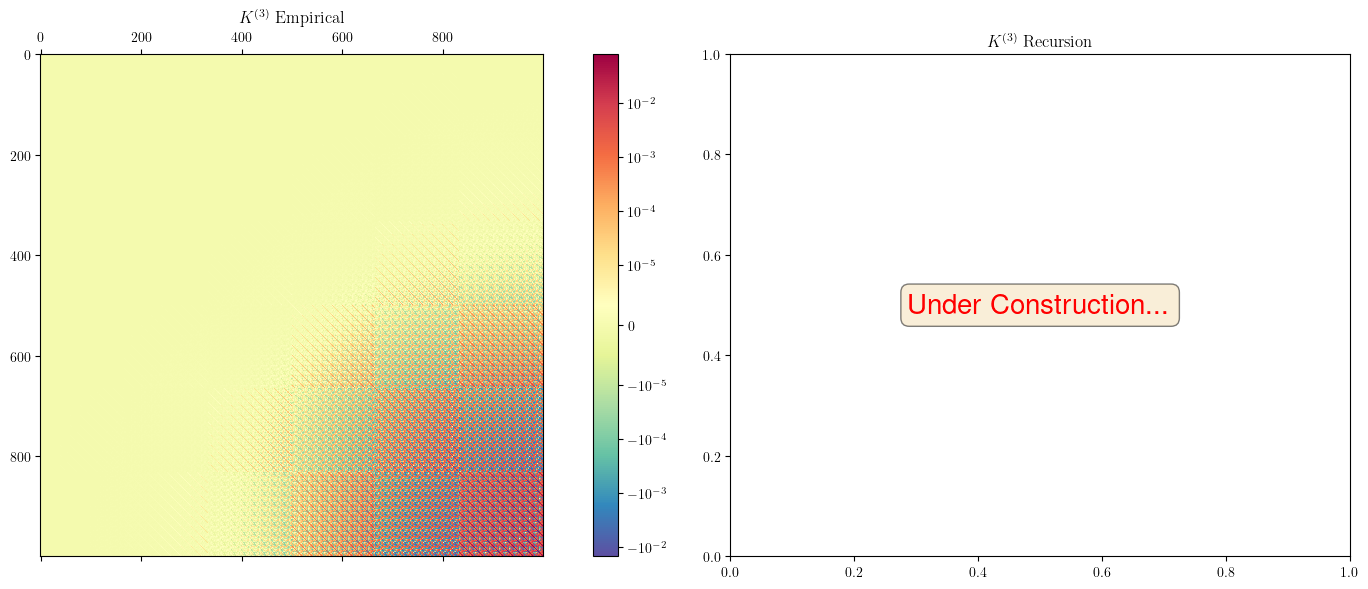

In [147]:
# Third layer
K3_empirical = compute_K_by_layer(models, 2).get_mean(axis=0)
K3_empirical = K3_empirical.reshape((K3_empirical.shape[0] * K3_empirical.shape[1], K3_empirical.shape[2] * K3_empirical.shape[3]))

# Create a new figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fig1, axes[0] = plot_matrix(K3_empirical, ax=axes[0])
#fig2, axes[1] = plot_matrix(K1_infinity, ax=axes[1])
axes[1].text(0.5, 0.5, "Under Construction...", color='red', fontsize=20, transform=axes[1].transAxes,
             verticalalignment='center', horizontalalignment='center', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add titles
axes[0].set_title(r"$K^{(3)} \textrm{ Empirical}$")
axes[1].set_title(r"$K^{(3)} \textrm{ Recursion}$")

plt.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'K3_correlations.pdf', dpi=300)

# Recursion relation for the kernel

1.14456182484638e-89


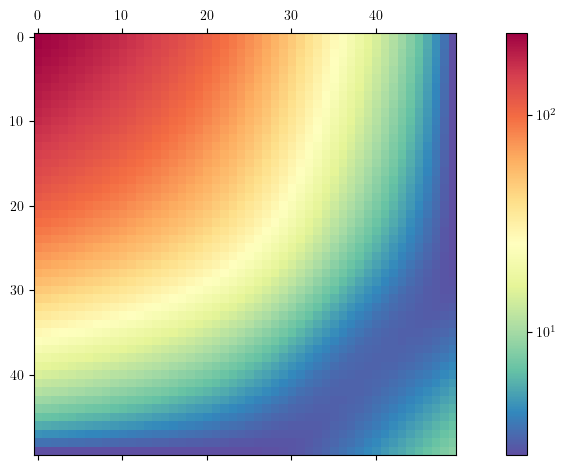

In [18]:
X = np.array([[x, np.log(x), np.exp(x)] for x in fk_grid])
XX = np.einsum('aj,bj->ab', X, X) + np.identity(X.shape[0]) * 1e-2
plot_matrix(XX)
print(np.linalg.det(XX))

0.0


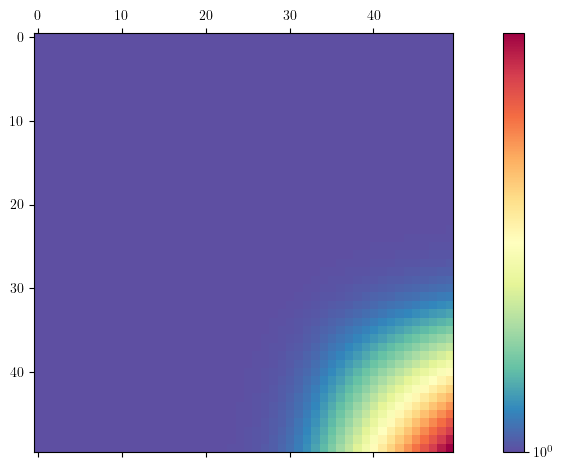

In [ ]:
XX = np.outer(fk_grid, fk_grid)
delta = 1.e-4
K_1 = np.ones_like(XX) + XX  #delta * np.eye(len(fk_grid))
plot_matrix(K_1)

In [56]:
class MultivariateGaussian:
    def __init__(self, mean, covariance):
        """
        Initialize the multivariate Gaussian distribution.

        Args:
            mean (np.ndarray): Mean vector of the distribution.
            covariance (np.ndarray): Covariance matrix of the distribution.
        """
        self.mean = mean
        self.covariance = covariance
        self.dim = mean.shape[0]

    def pdf(self, x):
        """
        Compute the probability density function (PDF) at point x.

        Args:
            x (np.ndarray): Point at which to evaluate the PDF.

        Returns:
            float: The value of the PDF at point x.
        """
        diff = x - self.mean
        exponent = -0.5 * (diff.T @ np.linalg.inv(self.covariance) @ diff)
        normalization = 1 / np.sqrt((2 * np.pi) ** self.dim * np.linalg.det(self.covariance))
        return normalization * np.exp(exponent)


    def sample(self, num_samples):
        """
        Generate samples from the multivariate Gaussian distribution.

        Args:
            num_samples (int): Number of samples to generate.

        Returns:
            np.ndarray: Samples drawn from the distribution.
        """
        return np.random.multivariate_normal(self.mean, self.covariance, num_samples)

In [57]:
def compute_expectation_value(func, dist, lower_limit=None, upper_limit=None):
    """
    Compute the expectation value of a function with respect to a multivariate Gaussian distribution.
    """
    from scipy.integrate import nquad
    
    # Define the integrand
    def integrand(*args):
        point = np.array(args)
        return func(point) * dist.pdf(point)
    
    # Set integration limits
    if lower_limit is None:
        lower_limit = [-1.e-8] * dist.dim
    if upper_limit is None:
        upper_limit = [1.e-8] * dist.dim
    
    # Create ranges for nquad - must be a list of (lower, upper) tuples
    ranges = [(lower_limit[i], upper_limit[i]) for i in range(dist.dim)]
    
    # Perform the integration
    result, error = nquad(integrand, ranges)
    
    return result

In [17]:
def second_moment(x):
    return np.outer(x,x)

def first_moment(x):
    return x

# Create a multivariate Gaussian distribution
mvg = MultivariateGaussian(np.zeros(K_1.shape[0]), K_1)

In [58]:
def improved_monte_carlo(func, dist, num_samples=10000, batch_size=1000):
    """
    Monte Carlo with error estimation via batching
    """
    batch_results = []
    for _ in range(num_samples // batch_size):
        samples = dist.sample(batch_size)
        batch_results.append(np.mean([func(sample) for sample in samples], axis=0))
    
    return np.mean(batch_results, axis=0), np.std(batch_results, axis=0)/np.sqrt(len(batch_results))

In [22]:
first_moment_mean, first_moment_std = improved_monte_carlo(first_moment, mvg, num_samples=10000000, batch_size=10000)

In [59]:
second_moment_mean, second_moment_std = improved_monte_carlo(second_moment, mvg, num_samples=10000000, batch_size=1000)

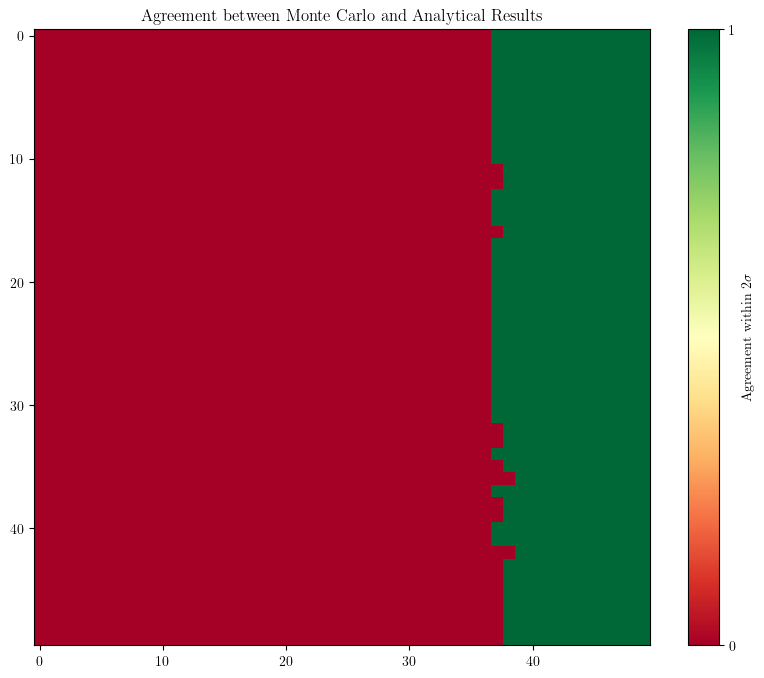

Agreement percentage: 25.24% of elements agree within 2σ


In [60]:
# Create agreement mask (True where difference is less than 2 standard deviations)
agreement_mask = np.abs(second_moment_mean - K_1) <= 2*first_moment_std

# Plot the boolean matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(agreement_mask, cmap='RdYlGn', interpolation='none')
plt.colorbar(im, ax=ax, ticks=[0, 1], label=r'$\textrm{Agreement within } 2\sigma$')
plt.title(r'$\textrm{Agreement between Monte Carlo and Analytical Results}$')
plt.show()

# Print percentage of elements that agree within uncertainties
agreement_percentage = 100 * np.sum(agreement_mask) / agreement_mask.size
print(f"Agreement percentage: {agreement_percentage:.2f}% of elements agree within 2σ")